<a href="https://colab.research.google.com/github/pc-Jiang/math_in_deep_learning/blob/main/DSC_291_SP23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSC 291 Mathmatics in Deep Learning, SP23
Advisor: Mikhail Belkin

Author: Pengcen Jiang, Bin Wang

## Import packages and set random seed.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import math
import numpy as np
import pandas as pd
from collections import OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
MAP_LOC = "cuda:0" if USE_CUDA else torch.device('cpu')

os.environ['NUMEXPR_MAX_THREADS'] = '16'
plt.rcParams.update({'font.size': 10})


def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

## Define basic blocks and functions. 

### Define configurations class. 

In [2]:
class LearnFixedPointConfig(object):
    def __init__(self):
        # params for model
        self.hidden_size = 100
        self.nonlinearity = None
        self.dim_in = 10
        self.batch_size = 1
        self.initialization = 'uniform'
        self.use_bias = False
        self.time_steps = 1
        self.ct = True
        self.tau = 1

        # params for training
        self.lr = 0.001
        self.optimizer_type = 'SGD'
        self.momentum = 0
        self.wdecay = 0
        self.num_ep = 5000
        self.add_noise_input = False
        self.add_noise_fp = False

        # params for generating data
        self.std_fp = 1
        self.mean_fp = 0
        self.std_inp = 1
        self.mean_inp = 0
        self.std_init = 1
        self.std_noise = 0.1
        self.mean_noise = 0
        

    def update(self, new_config):
        self.__dict__.update(new_config.__dict__)

    def __str__(self):
        return str(self.__dict__)

### Define the function to get different configs. 

In [3]:
def vary_config(base_config, config_ranges, mode,
                num_seed=1, default_name=False):
    """Return configurations.
    adapted from https://github.com/gyyang/olfaction_evolution
    Args:
        base_config: BaseConfig object, a base configuration
        config_ranges: a dictionary of hyperparameters values
            config_ranges = {
                'hp1': [hp1_val1, hp1_val2, ...],
                'hp2': [hp2_val1, hp2_val2, ...],
            }
        mode: str, can take 'combinatorial' or 'sequential'
        num_seed: int, number of random seeds
        default_name: bool, whether to use auto_name function
    Return:
        config_df: a pandas data frame of configs,
            each row is a config, each column is a variation of parameter
    """
    assert 'seed' not in config_ranges.keys(), 'seed cannot be specified in config range'

    keys = config_ranges.keys()
    dims = [len(config_ranges[k]) for k in keys]

    attribute_dict = {}
    for key in keys:
        attribute_dict[key] = []
    attribute_dict['seed'] = []
    attribute_dict['config'] = []

    # Return combinatorial configurations,
    # config_ranges should not have repetitive values
    if mode == 'combinatorial':
        n_max = int(np.prod(dims))
        assert n_max > 0
        for seed in range(num_seed):
            for i in range(n_max):
                new_config = deepcopy(base_config)
                # Set up new config
                new_config.seed = seed
                indices = np.unravel_index(i, shape=dims)
                for key, index in zip(keys, indices):
                    val = config_ranges[key][index]
                    setattr(new_config, key, val)
                    attribute_dict[key].append(val)

                attribute_dict['seed'].append(seed)
                attribute_dict['config'].append(new_config)

    # Return sequential configurations.
    # config_ranges values should have equal length,
    # otherwise this will only loop through the shortest one
    elif mode == 'sequential':
        n_max = np.min(dims)
        assert n_max > 0
        for seed in range(num_seed):
            for i in range(n_max):
                new_config = deepcopy(base_config)
                # Set up new config
                new_config.seed = seed
                for key in keys:
                    val = config_ranges[key][i]
                    setattr(new_config, key, val)
                    attribute_dict[key].append(val)

                attribute_dict['seed'].append(seed)
                attribute_dict['config'].append(new_config)
    else:
        raise ValueError('Unknown mode {}'.format(str(mode)))

    configs_df = pd.DataFrame(attribute_dict)

    for i, row in configs_df.iterrows():
        config = row.loc['config']
        if default_name:
            config.model_name = str(i).zfill(6)
        else:
            name = 'model'
            for key in keys:
                name += '_' + str(key) + str(row.loc[key])

            # replace char that are not suitable for path
            name = name.replace(",", "").replace(" ", "_")
            name = name.replace("[", "_").replace("]", "_").replace(".", "_")
            name = name.replace("'", "")
            config.model_name = name + '_s' + str(row.loc['seed'])

    return configs_df

def configs_df_unpack(configs_df):
    """
    unpack configs_df to a list of configs
    args:
        configs_df: pandas.DataFrame, that contains all configs in an experiment
    return:
        config_list: unpacked list of configs
    """
    config_list = list(configs_df.loc[:, 'config'])
    return config_list

### Define RNN class. 

In [4]:
class IdentityAct(object):
    def __call__(self, tensor):
        return tensor


class VanillaRNNCell(nn.Module):
    def __init__(self, config):
        super(VanillaRNNCell, self).__init__()
        self.input_size = config.dim_in
        # self.output_size = config.dim_in
        self.hidden_size = config.hidden_size
        self.nonlinearity = config.nonlinearity
        self.use_bias = config.use_bias
        self.initialization = config.initialization
        self.ct = config.ct
        self.tau = config.tau

        self.std_init = config.std_init

        self.weight_ih = nn.Parameter(
            torch.zeros((self.hidden_size, self.input_size)))
        self.weight_hh = nn.Parameter(
            torch.zeros((self.hidden_size, self.hidden_size)))
        # self.weight_ho = nn.Parameter(
        #     torch.zeros((self.output_size, self.hidden_size)))
        self.bias = nn.Parameter(torch.zeros(self.hidden_size, 1))
        # self.bias_out = nn.Parameter(torch.zeros(self.output_size, 1))
        self.reset_parameters()

        if self.nonlinearity is None:
            self.act = IdentityAct()
        elif self.nonlinearity == "tanh":
            self.act = torch.tanh
        elif self.nonlinearity == "relu":
            self.act = F.relu
        else:
            raise RuntimeError("Unknown nonlinearity: {}".format(
                self.nonlinearity))

    def reset_parameters(self):
        # todo input weight fixed
        # todo fixed point dimension = 100
        # add: bias-false
        stdv = 1.0 / math.sqrt(self.hidden_size) * self.std_init
        
        if self.initialization is None:
            for name, weight in self.named_parameters():
              if 'bias' in name:
                  if not self.use_bias:
                      weight.requires_grad = False
              if 'weight_ih' in name:
                  nn.init.uniform_(weight, -stdv, stdv)
                  weight.requires_grad = False

        elif self.initialization == 'uniform':
            for name, weight in self.named_parameters():
                if 'bias' in name:
                    if not self.use_bias:
                        weight.requires_grad = False
                    else:
                        nn.init.uniform_(weight, -stdv, stdv)
                if 'weight_ih' in name:
                    nn.init.uniform_(weight, -stdv, stdv)
                    weight.requires_grad = False
                else:
                    nn.init.uniform_(weight, -stdv, stdv)
        else:
            raise RuntimeError("Unknown initialization: {}".format(self.initialization)) 

    def forward(self, inp, hidden_in):
        # print(inp.size())
        inp = torch.unsqueeze(inp, 2)
        # print(inp.size())
        hidden_in = torch.unsqueeze(hidden_in, 2)
        if self.ct:
            hidden_out = (1 - self.tau) * hidden_in \
                      + self.tau * (torch.matmul(self.weight_hh, self.act(hidden_in)) + \
                      torch.matmul(self.weight_ih, inp) + self.bias)
            # print(hidden_out.size(), self.weight_hh.size())
        else:
            hidden_out = torch.matmul(self.weight_hh, self.act(hidden_in)) + \
                      torch.matmul(self.weight_ih, inp) + self.bias
            
        # output = torch.matmul(self.weight_ho, hidden_out) + self.bias_out
        # hidden_out = torch.squeeze(hidden_out, 2)
        # output = torch.squeeze(output, 2)

        output = torch.matmul(self.weight_hh, self.act(hidden_in)) + \
                      torch.matmul(self.weight_ih, inp) + self.bias - \
                      hidden_in

        return [hidden_out, output]

    def init_hidden(self, batch_s):
        return torch.zeros(batch_s, self.hidden_size).to(DEVICE)

### Define the function to get the fixed point and input. 

In [5]:
def get_fixed_point(config):
    fixed_point = torch.randn(config.batch_size, config.hidden_size).to(DEVICE) * config.std_fp + config.mean_fp
    return fixed_point

def get_input(config):
    dim = config.dim_in
    input = torch.randn(config.batch_size, config.dim_in).to(DEVICE) * config.std_inp + config.mean_inp
    return input

def add_noise(datum, mean=0, std=0.1):
    return datum + torch.randn(datum.size()).to(DEVICE) * std + mean

### Define the training function. 

Basic training function. 

In [6]:
def train_fixed_point(config, model, fixed_point, input, print_log=False):
    # initialize optimizer
    if config.optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,
                        model.parameters()),
                        lr=config.lr,
                        weight_decay=config.wdecay)
    elif config.optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad,
                       model.parameters()),
                       lr=config.lr,
                       momentum=config.momentum,
                       weight_decay=config.wdecay)
    else:
        raise NotImplementedError('optimizer not implemented')

    criterion = nn.MSELoss()
    task_loss_list = []
    ep_list = []
    count = 1
    
    for ep in range(config.num_ep):
        target_data = torch.zeros(config.batch_size, config.hidden_size, 1).to(DEVICE);
        hidden = fixed_point
        model.train()
        loss = 0.0 
        optimizer.zero_grad()
        for step in range(config.time_steps):
            if config.add_noise_input:
                input = add_noise(input, config.mean_noise, config.std_noise)
            if config.add_noise_fp:
                hidden = add_noise(hidden, config.mean_noise, config.std_noise)

            [hidden, output] = model(input, hidden)
            task_loss = criterion(output, target_data)
            # print(target_data.size(), output.size(), hidden.size())
            # print(task_loss)
            loss += task_loss

        loss.backward()
        optimizer.step()
        task_loss_list.append((loss/config.time_steps).item())
        ep_list.append(count)
        if print_log:
            if count % 100 == 0: 
                print('TRAIN | Epoch: {}/{} | Loss: {:.2f}'.format(ep+1, config.num_ep, loss/config.time_steps))
        count += 1

    return model, optimizer, task_loss_list, ep_list


Training a set of tasks with different hyperparameters. 

In [7]:
def train_from_configs(configs_df, print_log=False):

    configs = configs_df_unpack(configs_df)
    results = []
    for i, config in enumerate(configs):
        
        model = VanillaRNNCell(config)
        fixed_point = get_fixed_point(config)
        input = get_input(config)
        # print('Fixed point {} \n'.format(fixed_point))
        model, optimizer, task_loss_list, ep_list = train_fixed_point(config, model, fixed_point, input, print_log)

        result = {}
        result['config'] = config
        result['fixed_point'] = fixed_point.cpu().numpy()
        result['model'] = model
        result['task_loss_list'] = task_loss_list
        result['ep_list'] = ep_list
        result['input'] = input.cpu().numpy()
        results.append(result)
        if print_log: 
            print('Finish training model {}'.format(i+1))
    return results

Training the task of same hyperparameters with several repetitions. 

In [8]:
def get_training_variance(configs_df, rep=10, print_log=False):
    results_reps = []
    
    for i in range(rep):
        # print(rep)
        results = train_from_configs(configs_df, print_log)
        results_reps.append(results)
        print('Finish training {} th round'.format(i+1))
        if print_log:
            print('------------------------------------------------------------------------------')

    return results_reps

### Define functions to do analysis. 

Get the eigenvalues and eigenvectors of the Jacobbian matrix of the RNN network. 

In [9]:
def get_Jacobian_eigenvalue(weight_h, config, fixed_point):

    # fixed_point = fixed_point.detach().cpu().numpy()
    weight_h = weight_h.detach().cpu().numpy()

    J = -np.eye(config.hidden_size)

    if config.nonlinearity is None:
        J += weight_h
    elif config.nonlinearity == "tanh":
        grad = np.squeeze(1 / (np.cosh(fixed_point))**2)
        grad_diag = np.diag(grad)
        J += weight_h @ grad_diag
    elif config.nonlinearity == "relu":
        grad = np.squeeze(np.heaviside(fixed_point, 0))
        grad_diag = np.diag(grad)
        J += weight_h @ grad_diag
    else:
        raise RuntimeError("Unknown nonlinearity: {}".format(
              self.nonlinearity))
    
    val, vec = np.linalg.eig(J)
    val = val[np.argsort(-val.real)] # size n np.array
    vec = vec[:, np.argsort(-val.real)]

    return val, vec

Get the deviation of the real part of the largest eigenvalue by training multiple repetitions. 

In [10]:
def get_eigenvalue_variance(results_reps):
    rep = len(results_reps)
    n = len(results_reps[0])
    max_eig_vals = np.zeros((rep, n))

    for i in range(rep):
        for j, r in enumerate(results_reps[i]):
            weight_h = r['model'].weight_hh
            vals, _ = get_Jacobian_eigenvalue(weight_h, r['config'], r['fixed_point'])
            max_eig_vals[i, j] = vals[0].real
    
    return np.mean(max_eig_vals, 0), np.std(max_eig_vals, axis=0, ddof=1)

Plot the training loss and eigenvalues. 

In [11]:
def analyze_single_result(result_list, variable_list, mean_eigval=None, std_eigval=None):
    print(mean_eigval)
    print(std_eigval)
    n_eig = 8
    legends = []
    fig = plt.figure(figsize=(12,6))
    ax1 = plt.axes([0.10, 0.55, 0.9, 0.34])
    ax2 = plt.axes([0.10, 0.10, 0.4, 0.34])
    ax3 = plt.axes([0.6, 0.10, 0.4, 0.34])
    palette = np.array(sns.color_palette("hls", len(result_list)))
    title = ''
    for i, r in enumerate(result_list):
        legend = []
        for var in variable_list: 
            var_val = getattr(r['config'], var)
            legend += [str(var_val)]
        legends += [legend]

        ax1.plot(r['ep_list'], r['task_loss_list'], color=palette[i])

        weight_h = r['model'].weight_hh
        vals, _ = get_Jacobian_eigenvalue(weight_h, r['config'], r['fixed_point'])
        ax2.plot(range(1, n_eig+1), vals[:n_eig].real, color=palette[i])
        if mean_eigval is None: 
            ax3.scatter(i+1, vals[0].real, color=palette[i])
        else:
            ax3.scatter(i+1, mean_eigval[i], color=palette[i])
            ax3.errorbar(i+1, mean_eigval[i], yerr=std_eigval[i], color=palette[i], capsize=6)
        
    ax1.set_title('Training loss')
    ax1.set_xlabel('# training')
    _, y_max=ax1.get_ylim()
    ax1.set_ylim(0, min(y_max,4))
    ax2.set_title('Eigenvalue (Real)')
    ax2.set_xlabel('rank')
    ax2.hlines(0, 1, n_eig, linestyles='--')
    ax1.legend(legends)
    ax3.hlines(0, 1, len(result_list), linestyles='--', color='red')
    ax3.set_title('largest eigenvalue (real)')
    # plt.tight_layout(pad=0.5)
    plt.suptitle(', '.join(variable_list))
    plt.show()
    
    return fig, ax1, ax2, ax3

Get the overall result of several repetitions. 

In [12]:
def analyze_result(result_reps, variable_list): 
    mean_eigval, std_eigval = get_eigenvalue_variance(result_reps)
    analyze_single_result(result_reps[0], variable_list, mean_eigval, std_eigval)


## Train and analyze the network. 

### Train and get results. 

#### Influence of nonlinearity and initialization. 

Finish training 1 th round
Finish training 2 th round
Finish training 3 th round
Finish training 4 th round
Finish training 5 th round
Finish training 6 th round
Finish training 7 th round
Finish training 8 th round
Finish training 9 th round
Finish training 10 th round
[ 0.00168096  0.00307102 -0.02849639 -0.00890029 -0.54072988 -0.5215035 ]
[0.0222577  0.01504727 0.02379323 0.0224499  0.0243151  0.04593182]


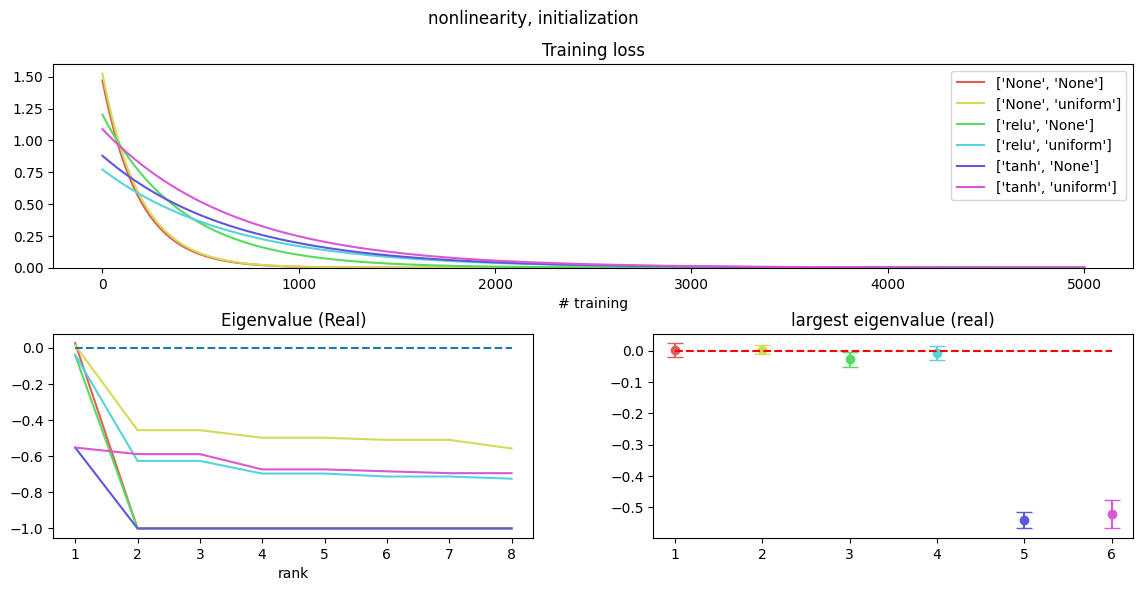

In [ ]:
def learn_fixed_point_nonlin_init():
    config = LearnFixedPointConfig()
    config_ranges = OrderedDict()
    config_ranges['nonlinearity'] = [None, 'relu', 'tanh']
    config_ranges['initialization'] = [None, 'uniform']
    configs = vary_config(config,
                config_ranges,
                mode='combinatorial',
                num_seed=1)
    return configs

configs_df = learn_fixed_point_nonlin_init()
nonlin_init_result = get_training_variance(configs_df)
analyze_result(nonlin_init_result, configs_df.columns.values[:-2])

#### Influence of magtitude of fixed point and initialization. 

Finish training 1 th round
Finish training 2 th round
Finish training 3 th round
Finish training 4 th round
Finish training 5 th round
Finish training 6 th round
Finish training 7 th round
Finish training 8 th round
Finish training 9 th round
Finish training 10 th round
[-6.75264597e-01 -4.13288977e-01  4.72089274e+00  2.41245366e-04
 -2.10338360e-03  4.64999145e+00 -6.55061503e-05 -1.30433292e-03
  4.57997631e+00]
[5.33998794e-02 1.96912317e-02 5.21337301e-01 2.25318737e-03
 2.05047870e-02 2.40708511e-01 1.86521875e-04 2.77205533e-03
 2.22267160e-01]


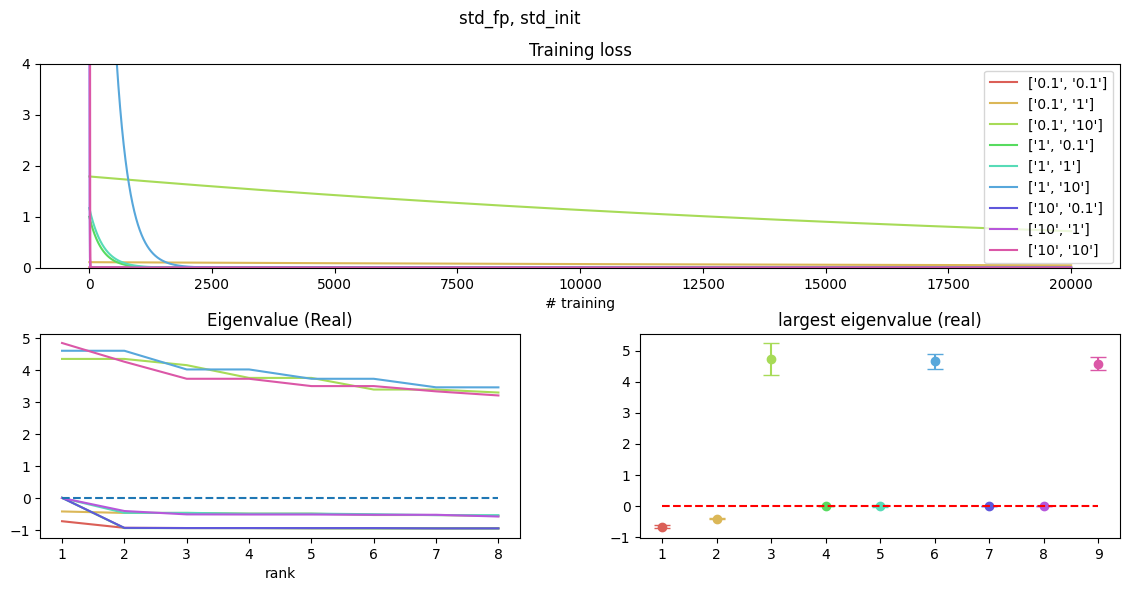

In [14]:
def learn_fixed_point_std():
    config = LearnFixedPointConfig()
    config_ranges = OrderedDict()
    config.num_ep = 20000
    config_ranges['std_fp'] = [0.1, 1, 10]
    config_ranges['std_init'] = [0.1, 1, 10]
    configs = vary_config(config,
                config_ranges,
                mode='combinatorial',
                num_seed=1)
    return configs

configs_df = learn_fixed_point_std()
std_result = get_training_variance(configs_df)
analyze_result(std_result, configs_df.columns.values[:-2])

#### Influence of adding noise to input and the fixed point. 

Finish training 1 th round
Finish training 2 th round
Finish training 3 th round
Finish training 4 th round
Finish training 5 th round
Finish training 6 th round
Finish training 7 th round
Finish training 8 th round
Finish training 9 th round
Finish training 10 th round
[ 0.0047805   0.01322924 -0.06367109 -0.05210856]
[0.01947016 0.02292396 0.11595427 0.09150206]


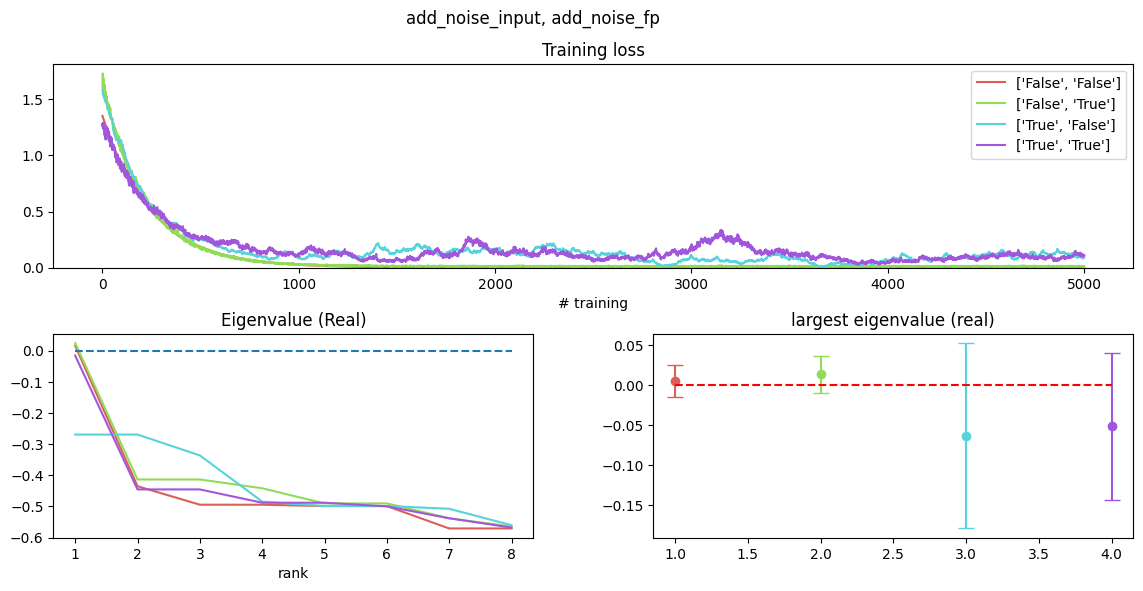

In [13]:
def learn_fixed_point_noise():
    config = LearnFixedPointConfig()
    config_ranges = OrderedDict()
    config_ranges['add_noise_input'] = [False, True]
    config_ranges['add_noise_fp'] = [False, True]
    configs = vary_config(config,
                config_ranges,
                mode='combinatorial',
                num_seed=1)
    return configs

configs_df = learn_fixed_point_noise()
noise_result = get_training_variance(configs_df)
analyze_result(noise_result, configs_df.columns.values[:-2])

#### Influence of input dimension and hidden size of RNN. 

Finish training 1 th round
Finish training 2 th round
Finish training 3 th round
Finish training 4 th round
Finish training 5 th round
Finish training 6 th round
Finish training 7 th round
Finish training 8 th round
Finish training 9 th round
Finish training 10 th round
[ 8.15200110e-02 -1.20726494e-01  4.66806744e-01 -3.53799057e-03
 -1.32203810e-02 -1.23121971e-01  6.16513305e-04  4.34706592e-04
 -4.57938731e-03]
[0.24040376 0.22944307 1.18023247 0.02505651 0.06713184 0.21096442
 0.00182779 0.00612459 0.02273144]


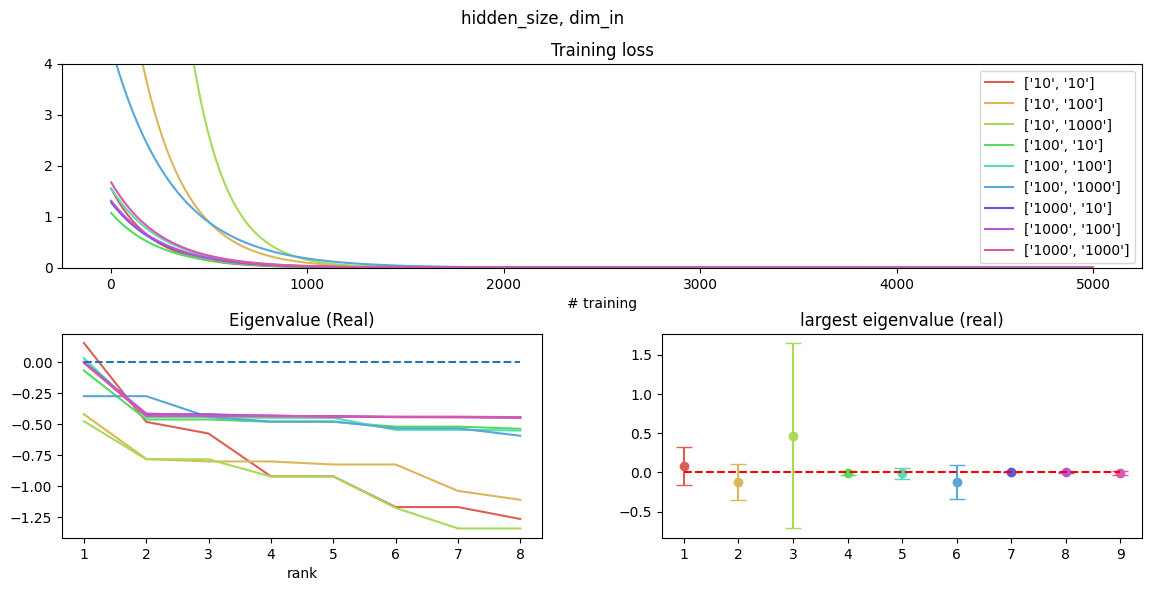

In [ ]:
def learn_fixed_point_dim():
    config = LearnFixedPointConfig()
    config_ranges = OrderedDict()
    config_ranges['hidden_size'] = [10,100,1000]
    config_ranges['dim_in'] = [10,100,1000]
    configs = vary_config(config,
                config_ranges,
                mode='combinatorial',
                num_seed=1)
    return configs

configs_df = learn_fixed_point_dim()
dim_result = get_training_variance(configs_df)
analyze_result(dim_result, configs_df.columns.values[:-2])

#### Influence of multiple fixed points. 

Finish training 1 th round
Finish training 2 th round
Finish training 3 th round
Finish training 4 th round
Finish training 5 th round
Finish training 6 th round
Finish training 7 th round
Finish training 8 th round
Finish training 9 th round
Finish training 10 th round
[-0.0062973   0.03014886 -0.17759355 -0.27316239]
[0.02694488 0.01994276 0.01886542 0.02038236]


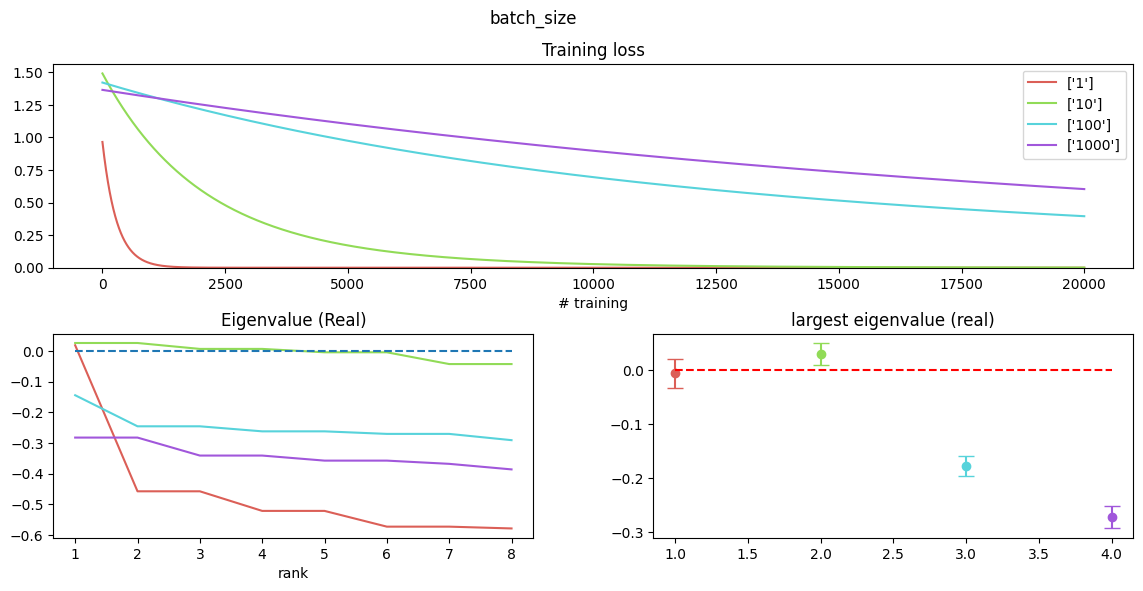

In [15]:
def learn_fixed_point_multiple():
    config = LearnFixedPointConfig()
    config.num_ep = 20000
    config_ranges = OrderedDict()
    config_ranges['batch_size'] = [1, 10, 100, 1000]
    configs = vary_config(config,
                config_ranges,
                mode='combinatorial',
                num_seed=1)
    return configs

configs_df = learn_fixed_point_multiple()
multiple_result = get_training_variance(configs_df)
analyze_result(multiple_result, configs_df.columns.values[:-2])